In [29]:
%pip install pygeodyntools --upgrade

Note: you may need to restart the kernel to use updated packages.


In [30]:
import pygeotools
import torch
import torch.nn as nn
import numpy
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm


### Retrieving the data

In [31]:
model_path = "E:\INTERNSHIP\PINN\Code\COVOBS-x2_400reals.hdf5"

pygeo = pygeotools.pygeotools()
model_name=  "COVOBS-x2_400reals.hdf5"
pygeo.loadModel(
    modelName="COVOBS-x2_400reals.hdf5",
    modelType="covobs_hdf5",
    modelPath="COVOBS-x2_400reals.hdf5"
)


pygeo.isLoaded("COVOBS-x2_400reals.hdf5")  # Should return True

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Hp\AppData\Local\Temp\ipykernel_20068\3761006966.py:1: SyntaxWarning: invalid escape sequence '\I'
  model_path = "E:\INTERNSHIP\PINN\Code\COVOBS-x2_400reals.hdf5"


pygeotools was initialized with `verbose=True`.


True

In [32]:
# Setting the grid
pygeo.setGrid("1deg")

# Creating the context
context = {
    "lmax": 13,
    "r": pygeo.constants["rCore"]
}

In [33]:
# Computing the MF and SV
MF = pygeo.addMeasure("COVOBS-x2_400reals.hdf5", "MF", context)
SV = pygeo.addMeasure("COVOBS-x2_400reals.hdf5", "SV", context)

13


In [34]:
# Retrieving the grid
_, (thetas, phis) = pygeo.getCurrentGrid()

In [35]:
# Selecting the data
Br = pygeo.selectFromMeasure("COVOBS-x2_400reals.hdf5", MF, options={"component": "r", "time": 2020})
dBrdt = pygeo.selectFromMeasure("COVOBS-x2_400reals.hdf5", SV, options={"component": "r", "time": 2020})


In [36]:
dBrdth_full = numpy.gradient(Br,   thetas, axis=0)
dBrdph_full = numpy.gradient(Br,   phis,   axis=1)


Generating patches

In [37]:
def generate_patches(theta_size=30, phi_size=30, overlap=5):# 20 rows longitude, 20 cols latitude
    patches = []
# without overlap
    dtheta = theta_size - overlap
    dphi = phi_size - overlap

#going from pole to pole (0 to 180 in colatitude) by stepping in 15° chunks (because dtheta = 15)
    for i1 in range(0, 180 - theta_size + 1, dtheta):
        i2 = i1 + theta_size
        for j1 in range(0, 360 - phi_size + 1, dphi):
            j2 = j1 + phi_size

            patches.append((i1, i2, j1, j2))

    return patches
'''
This loop creates a full list of (i1, i2, j1, j2) — patches of size 20°×20°, sliding across the whole globe, overlapping 5°.

Each patch will be used to train a small PINN, then all will be stitched together into one global map.
'''

patches = generate_patches(theta_size=20, phi_size=20, overlap=5)

for i1, i2, j1, j2 in patches:
    ... # For each patch, we have to solve the inverse problem

### Defining the NN model

In [38]:
node_inputs = 2
node_outputs = 2
node_layer = 20
hidden_layers = 10

In [39]:
#  Defining the NN
# For now, it has one hidden layer with 32 nodes
# The activation functions are TANH
class CoreFlowPINN(nn.Module):
    def __init__(self):
        super(CoreFlowPINN, self).__init__()

        layers = []

        layers.append(nn.Linear(node_inputs, node_layer))
        layers.append(nn.Tanh())

        for _ in range(hidden_layers):
            layers.append(nn.Linear(node_layer, node_layer))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(node_layer, node_outputs))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [40]:

r = torch.tensor(pygeo.constants["rCore"]) # placing ourselves at the CMB


def compute_loss(model, inputs, thetas_nn, phis_nn, Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn, alpha=1):
    u_pred = model(inputs)

    T = u_pred[:, 0:1]
    S = u_pred[:, 1:2]

    dT_dth = torch.autograd.grad(T, thetas_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dT_dph = torch.autograd.grad(T, phis_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dS_dth = torch.autograd.grad(S, thetas_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]
    dS_dph = torch.autograd.grad(S, phis_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]

    sin_th = torch.sin(thetas_nn)
    cos_th = torch.cos(thetas_nn)
    tan_th = torch.tan(thetas_nn)

    u_th = -dT_dph / sin_th + dS_dth
    u_ph = dT_dth + dS_dph / sin_th

    u_th_sin_th = u_th * sin_th
    d_u_th_sin_th_dth = torch.autograd.grad(u_th_sin_th, thetas_nn, grad_outputs=torch.ones_like(u_th_sin_th), create_graph=True, retain_graph=True)[0]
    d_u_ph_dph = torch.autograd.grad(u_ph, phis_nn, grad_outputs=torch.ones_like(u_ph), create_graph=True, retain_graph=True)[0]

    divH_uH = (1 / (r * sin_th)) * (d_u_th_sin_th_dth + d_u_ph_dph)

    gradH_Br_th = (1 / r) * dBrdth_nn
    gradH_Br_ph = (1 / (r * sin_th)) * dBrdph_nn

    L1 = dBrdt_nn + Br_nn * divH_uH + u_th * gradH_Br_th + u_ph * gradH_Br_ph
    L1_loss = (L1**2).mean()

    L2 = divH_uH - u_th * tan_th / r
    L2_loss = (L2**2).mean()

    N1_sq = dBrdt_nn.pow(2).mean()

    N2_sq = 1e-4


    L1_loss_final = L1_loss / N1_sq
    L2_loss_final = alpha * (L2_loss / N2_sq)

    # Final loss with tunable alpha
    total_loss = L1_loss_final + L2_loss_final
    return L1, total_loss, L1_loss_final, L2_loss_final, u_th, u_ph

    

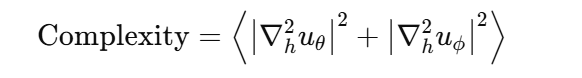

In [41]:
import torch

def compute_squared_complexity(u_th: torch.Tensor,
                               u_ph: torch.Tensor,
                               thetas: torch.Tensor,
                               phis:   torch.Tensor,
                               r:      float,
                               eps:    float = 1e-6) -> torch.Tensor:
    """
    Compute ⟨ |∇ₕ²u_th|² + |∇ₕ²u_ph|² ⟩ over the inputs (mean of squares).
    - u_th, u_ph : (N,1) horizontal flow components as functions of thetas, phis
    - thetas, phis : (N,1) input angles in radians (with requires_grad=True)
    - r : radius (e.g. CMB radius) in same length units as desired
    Returns:
      squared_complexity : scalar Tensor in (length/time)² units
    """

    
    def _autograd(tensor, wrt):
        return torch.autograd.grad(
            outputs=tensor, inputs=wrt,
            grad_outputs=torch.ones_like(tensor),
            create_graph=True, retain_graph=True
        )[0]

    # ensure no divide‑by‑zero at the poles
    sin_th = torch.sin(thetas).clamp(min=eps)

    # ∇ₕ² u_th
    d_u_th_dth = _autograd(u_th, thetas)
    d_sin_th_d_u_th_dth_dth = _autograd(sin_th * d_u_th_dth, thetas)
    d_u_th_dph  = _autograd(u_th, phis)
    d2_u_th_d2ph = _autograd(d_u_th_dph, phis)

    lap_h_u_th = (
        (1 / (r**2 * sin_th)) * d_sin_th_d_u_th_dth_dth
      + (1 / (r * sin_th)**2) * d2_u_th_d2ph
    )

    # ∇ₕ² u_ph
    d_u_ph_dth = _autograd(u_ph, thetas)
    d_sin_th_d_u_ph_dth_dth = _autograd(sin_th * d_u_ph_dth, thetas)
    d_u_ph_dph  = _autograd(u_ph, phis)
    d2_u_ph_d2ph = _autograd(d_u_ph_dph, phis)

    lap_h_u_ph = (
        (1 / (r**2 * sin_th)) * d_sin_th_d_u_ph_dth_dth
      + (1 / (r * sin_th)**2) * d2_u_ph_d2ph
    )

    # mean of squared Laplacians
    complexity = (lap_h_u_th**2 + lap_h_u_ph**2).mean()
    return complexity


In [ ]:
# Training over all patches
num_realizations = 1 # 5 time on each patch
epochs = 10000
λ      = 100



patch_centers=[]
loss_history = []
L1_history   = []
L2_history   = []


print(f"Number of times each patch will run: {num_realizations}")
print(f"Number of epochs: {epochs}")


patch_centers = []

# for less time consumption, I am using 50 patches
test_patches = patches[ 24:25 ] # you can slice it if u want less, that is why i created a seperate variable

print(test_patches)

print(f"Training on {len(test_patches)} patches")


#test_patches = [[]]

print(f"Number of patches: {len(patches)} but we will consider : {len(test_patches)}")

for patch_idx, (i1, i2, j1, j2) in enumerate(test_patches, start=1):
    # Skip poles and equator patches if needed
    if i1 < 10 or i2 > 170 or (i1 <= 90 <= i2):
      continue


    print(f"Processing from patch {patch_idx} Since the ones before were either equator or pole") # To know when it is starting and what is getting out of calculation


    # 1) slice the data & precomputed gradients
    Br_patch     = Br          [i1:i2, j1:j2, ...]
    dBrdt_patch  = dBrdt       [i1:i2, j1:j2, ...]
    dBrdth_patch = dBrdth_full[i1:i2, j1:j2, ...]
    dBrdph_patch = dBrdph_full[i1:i2, j1:j2, ...]

    # 2) slice the angles & mesh
    thetas_bis = thetas[i1:i2]
    phis_bis   = phis  [j1:j2]
    thg, phg   = numpy.meshgrid(thetas_bis, phis_bis, indexing="ij")
    th_flat    = thg.ravel()[:, None]
    ph_flat    = phg.ravel()[:, None]

    # 3) build torch tensors
    thetas_nn = torch.tensor(th_flat,   dtype=torch.float32, requires_grad=True)
    phis_nn   = torch.tensor(ph_flat,   dtype=torch.float32, requires_grad=True)
    Br_nn     = torch.tensor(Br_patch   .flatten()[:, None], dtype=torch.float32)
    dBrdt_nn  = torch.tensor(dBrdt_patch.flatten()[:, None], dtype=torch.float32)
    dBrdth_nn = torch.tensor(dBrdth_patch.flatten()[:, None], dtype=torch.float32)
    dBrdph_nn = torch.tensor(dBrdph_patch.flatten()[:, None], dtype=torch.float32)

    inputs = torch.cat([thetas_nn, phis_nn], dim=1)

    inputs = inputs.contiguous()


    
    

    for run in range(num_realizations):
        print(f"\n=== Training run {run+1}/{num_realizations} on patch {patch_idx} ===")

        model = CoreFlowPINN()
        with torch.no_grad():
            final_layer = model.net[-1]
            final_layer.weight += 20
            final_layer.bias.zero_()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


        from torch.optim.lr_scheduler import CosineAnnealingLR

        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=epochs,    # one full cosine cycle over your total epochs
            eta_min=1e-6     #  floor learning rate
        )
        

        # ensure gradients on inputs
        thetas_nn.requires_grad_(True)
        phis_nn.  requires_grad_(True)

        for epoch in range(1, epochs+1):
            optimizer.zero_grad()

            # compute the losses *and* retrieve u_th, u_ph
            L1, total_loss, L1_loss_final, L2_loss_final, u_th, u_ph = compute_loss(model, inputs, thetas_nn, phis_nn, Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn, alpha = 1)
    

            comp2 = compute_squared_complexity(
                u_th, u_ph,
                thetas_nn, phis_nn,
                r=pygeo.constants["rCore"]
            )
            
            Loss_main = total_loss
            Loss_main.backward()
            optimizer.step()
            scheduler.step()


            if epoch % 100 == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch:4d} | L1 {L1_loss_final:.2e} | L2 {L2_loss_final:.2e} ")

            # record histories
            loss_history.append(Loss_main.item())
            L1_history.append(L1_loss_final.item())
            L2_history.append(L2_loss_final.item())

        # after training
        print("Final squared complexity:", comp2.item())

    patch_centers.append(((i1 + i2)//2, (j1 + j2)//2))

print("Done computing for all patches.")


Number of times each patch will run: 1
Number of epochs: 10000
[(15, 35, 15, 35)]
Training on 1 patches
Number of patches: 253 but we will consider : 1
Processing from patch 1 Since the ones before were either equator or pole

=== Training run 1/1 on patch 1 ===
Epoch  100 | L1 1.03e-01 | L2λ 2.82e-02 
Epoch  200 | L1 4.58e-02 | L2λ 1.58e-02 
Epoch  300 | L1 4.54e-02 | L2λ 1.29e-02 
Epoch  400 | L1 5.05e-02 | L2λ 1.18e-02 
Epoch  500 | L1 4.14e-02 | L2λ 1.13e-02 
Epoch  600 | L1 3.92e-02 | L2λ 1.08e-02 
Epoch  700 | L1 9.11e-02 | L2λ 9.37e-03 
Epoch  800 | L1 4.18e-02 | L2λ 1.16e-02 
Epoch  900 | L1 3.57e-02 | L2λ 1.02e-02 
Epoch 1000 | L1 3.87e-02 | L2λ 1.14e-02 
Epoch 1100 | L1 3.17e-02 | L2λ 8.49e-03 
Epoch 1200 | L1 2.78e-02 | L2λ 8.73e-03 
Epoch 1300 | L1 2.68e-02 | L2λ 8.65e-03 
Epoch 1400 | L1 2.51e-02 | L2λ 9.77e-03 


In [ ]:
import os
import json
import torch
from datetime import datetime

theta_size = 30
phi_size= 30
# 1) Define your constant base directory once
BASE_OUT_DIR = r"E:\INTERNSHIP\PINN\Code\training_outputs"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name  = f"patch_8_{i1}_{i2}_{j1}_{j2}_hl{hidden_layers}_nl{node_layer}_{timestamp}"
out_dir   = os.path.join(BASE_OUT_DIR, run_name)
os.makedirs(out_dir, exist_ok=True)
print("Saving everything to:", out_dir)

# 2) Build your checkpoint dict
checkpoint = {
    "params": {
        "model_name":    model_name,
        "node_inputs":   node_inputs,
        "node_outputs":  node_outputs,
        "node_layer":    node_layer,
        "hidden_layers": hidden_layers,
        "learning_rate": 0.001,
        "epochs":        epochs,
        "lamda":             λ,
        "patch":         (i1, i2, j1, j2),
        "theta_size":    theta_size,
        "phi_size":      phi_size,

    },
    "loss_history":         loss_history,
    "model_state_dict":     model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "final_epoch":          epoch,
}

# 3) Save the checkpoint into run_dir

save_path    = os.path.join(out_dir, "params_only_checkpoint.pth")
torch.save(checkpoint, save_path)
print(f"Saved checkpoint to {save_path}")

model.eval()
with torch.enable_grad():  # needed because compute_loss uses autograd.grad
    L1,_, _, _, _, _ = compute_loss(
        model, inputs, thetas_nn, phis_nn,
        Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn
    )
    
mae       = L1.abs().mean().item()
rmse      = torch.sqrt((L1**2).mean()).item()
obs_mean  = dBrdt_nn.abs().mean().item()
rel_err   = mae / obs_mean



metrics = {
    "rmse":       rmse,
    "mae":        mae,
    "rel_err":    rel_err,
    "complexity": comp2.item(),
    "region":     f"{(i1+i2)//2}° colatitude",
    **checkpoint["params"]
}
metrics_path = os.path.join(out_dir, "metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print(f" Wrote metrics to {metrics_path}")


Saving everything to: E:\INTERNSHIP\PINN\Code\training_outputs\patch_7_15_35_15_35_hl10_nl20_20250708_104841
Saved checkpoint to E:\INTERNSHIP\PINN\Code\training_outputs\patch_7_15_35_15_35_hl10_nl20_20250708_104841\params_only_checkpoint.pth
 Wrote metrics to E:\INTERNSHIP\PINN\Code\training_outputs\patch_7_15_35_15_35_hl10_nl20_20250708_104841\metrics.json


In [ ]:
# after computing comp2 = compute_squared_complexity(...)
print(f"Squared complexity (mean |∇ₕ²u|²): {comp2.item():.3e} (km/yr)²")


Squared complexity (mean |∇ₕ²u|²): 1.035e-10 (km/yr)²


In [ ]:


def relative_error_comparison(rel_err):

    threshold = 0.10  # 10% relative error
    if rel_err > threshold:
        print(f"Patch at {patch_centers}°: relative error {rel_err:.2%} exceeds 10% threshold ")
    else:
        print(f"Patch at {patch_centers}°: relative error {rel_err:.2%} is within acceptable bounds.")


compare = relative_error_comparison(rel_err)


print("-------------------------------------------------------------")
print(f"  MAE (L1)            = {mae:.3e}")
print(f"  |dBr/dt|_mean (obs) = {obs_mean:.3e}")
print(f"  Relative error      = {rel_err:.2f}")





Patch at [(25, 25)]°: relative error 20.77% exceeds 10% threshold 
-------------------------------------------------------------
  MAE (L1)            = 5.664e+02
  |dBr/dt|_mean (obs) = 2.727e+03
  Relative error      = 0.21


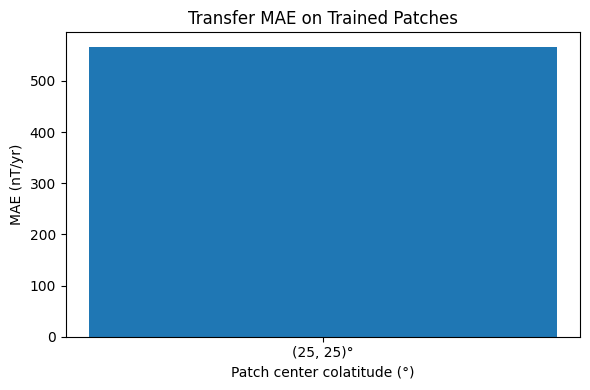

In [ ]:
plt.figure(figsize=(6,4))
x = range(len(patch_centers))
plt.bar(x, mae)
plt.xticks(x, [f"{c}°" for c in patch_centers])
plt.xlabel("Patch center colatitude (°)")
plt.ylabel("MAE (nT/yr)")
plt.title("Transfer MAE on Trained Patches")
plt.tight_layout()
plt.show()

### Predictions

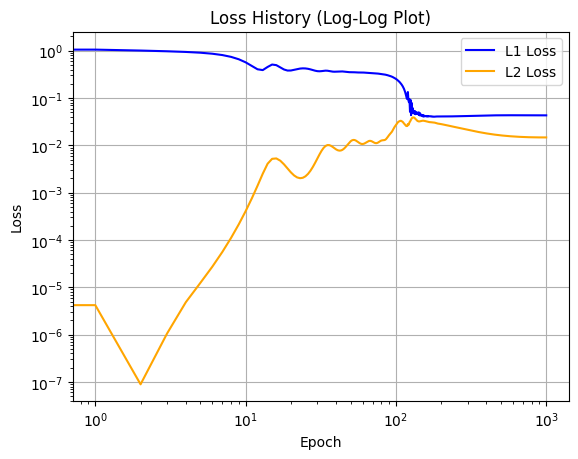

In [ ]:
import matplotlib.pyplot as plt
import torch


loss_history_np1 = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in L1_history]
loss_history_np2 = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in L2_history]

plt.loglog(loss_history_np1, label='L1 Loss', color='blue')
plt.loglog(loss_history_np2, label='L2 Loss', color='orange')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History (Log-Log Plot)')
plt.grid(True)
plt.savefig(os.path.join(out_dir, "Loss_L1_L2.png"))
plt.show()





In [ ]:

L1, total_loss, L1_loss_final, L2_loss_final, u_th, u_ph = compute_loss(
        model, inputs, thetas_nn, phis_nn,
        Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn
    )
def plot_sv_patch(Br_nn, L1, u_ph, u_th,
                  thetas_bis, phis_bis,
                  patch_id=None,
                  a=None,
                  title=None,
                  units=None):   # <-- new


    # Choose coloring data
    data = a if a is not None else Br_nn
    if hasattr(data, 'detach'):
        data = data.detach().numpy()

    # Build lat/lon grids
    theta_grid, phi_grid = np.meshgrid(thetas_bis, phis_bis, indexing='ij')
    lat_grid = 90 - np.rad2deg(theta_grid)
    lon_grid = np.rad2deg(phi_grid)

    # Create figure + map
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)

    
        # center zero in the colormap
    vmax = np.nanmax(np.abs(data))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

    sc = ax.scatter(lon_grid, lat_grid,
                    c=data,
                    cmap='seismic',   # red–white–blue
                    norm=norm,       # ensures 0→white
                    s=20,
                    transform=ccrs.PlateCarree())


    # Colorbar
    cb = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.05)
    cb_label = units if units else r'$\partial B_r / \partial t$ (SV)'
    cb.set_label(cb_label, fontsize=12)

 
    cb.set_ticks([-vmax, 0, vmax])


    # Title selection: use custom title if provided
    if title is not None:
        ax.set_title(title)
    else:
        default_title = f"SV Patch {patch_id}" if patch_id is not None else "SV Patch"
        ax.set_title(default_title)

    plt.tight_layout()
    return fig, ax




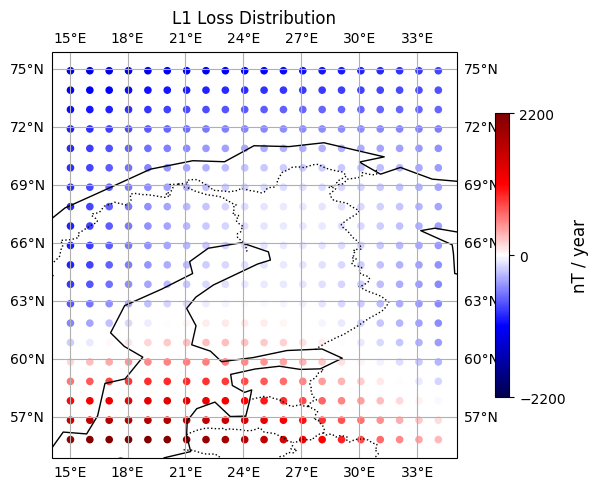

In [ ]:
fig, ax = plot_sv_patch(
    Br_nn,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=L1,
    title="L1 Loss Distribution",
    units="nT / year"         
)





plt.savefig(os.path.join(out_dir, "L1_Loss.png"))
plt.show()


In [ ]:
'''
fig, ax = plot_sv_patch(
    dBrdt_nn,
    Br_nn,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=dBrdt_nn.detach().numpy(),
    title="SV",
    units="SV"      
)

plt.savefig(os.path.join(out_dir, "Theta.png"))
plt.show()


'''


TypeError: plot_sv_patch() got multiple values for argument 'patch_id'

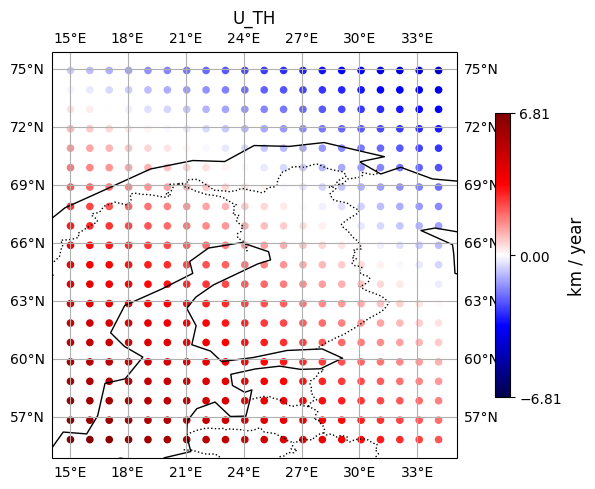

In [ ]:


fig, ax = plot_sv_patch(
    Br_nn,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=u_th.detach().numpy(),
    title="U_TH",
    units="km / year"      
)

plt.savefig(os.path.join(out_dir, "Theta.png"))
plt.show()





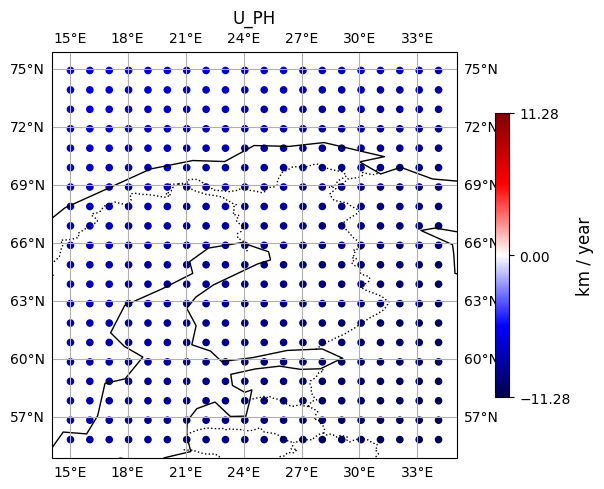

In [ ]:


fig, ax = plot_sv_patch(
    Br_nn,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=u_ph.detach().numpy(),
    title="U_PH",
    units="km / year"    )   

plt.savefig(os.path.join(out_dir, "Phi.png"))
plt.show()





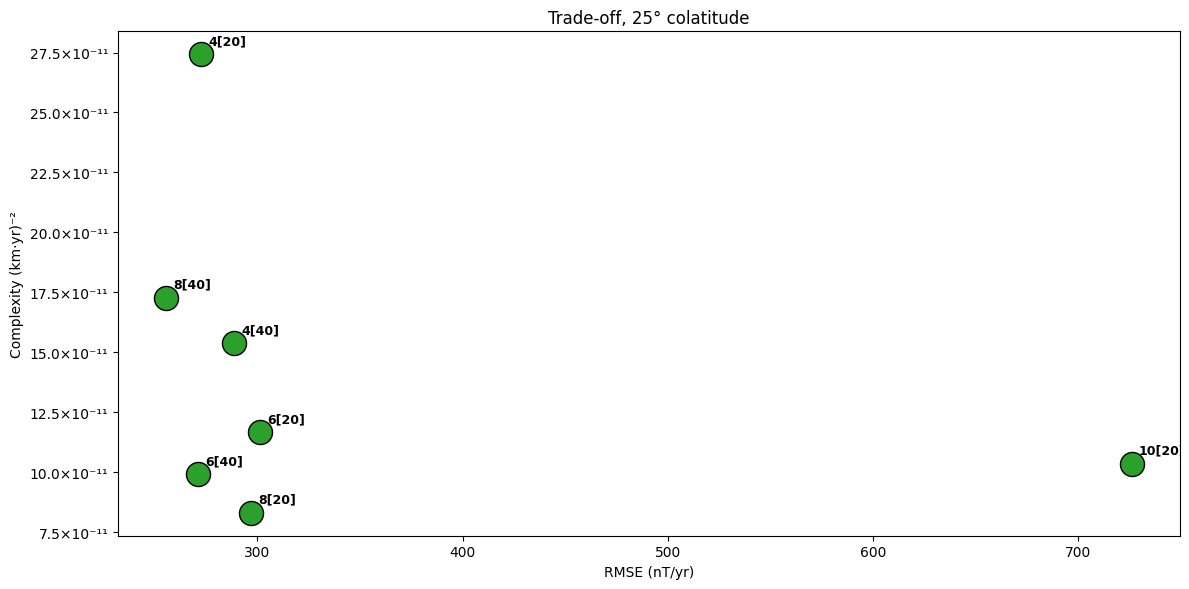

In [ ]:

import glob, json, os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# 1) Collect all metrics
files = glob.glob(os.path.join("training_outputs", "*", "metrics.json"))
records = []
for fn in files:
    m = json.load(open(fn))
    records.append({
        "region":        m["region"],
        "rmse":          m["rmse"],
        "complexity":    m["complexity"],
        "hidden_layers": m["hidden_layers"],
        "node_layer":    m["node_layer"],
    })
df = pd.DataFrame(records)
def fmt_1e11_with_offset(val, pos):
    scaled = val * 1e11
    return f"{scaled:.1f}×10⁻¹¹"

# 2) One subplot per region
regions = df.region.unique()
fig, axes = plt.subplots(figsize=(12,6))
plt.tight_layout(pad=2.0)
if len(regions)==1:
    axes = [axes]
    
from matplotlib.ticker import FuncFormatter

for ax, reg in zip(axes, regions):
    sub = df[df.region == reg]

    # 1) Plot raw complexity values
    ax.scatter(sub.rmse, sub.complexity, s=300,
               color="tab:green", edgecolor="k", linewidth=1)

    # 2) Annotate as before
    for _, row in sub.iterrows():
        ax.annotate(
            f"{row.hidden_layers}[{row.node_layer}]",
            xy=(row.rmse, row.complexity),
            xytext=(5,5),
            textcoords="offset points",
            fontsize=9, fontweight="bold", color="black",
            ha="left", va="bottom", clip_on=True
        )

    # 3) Force a single “×10⁻¹¹” offset on the y-axis
    fmt = mticker.ScalarFormatter(useMathText=True)
    fmt.set_scientific(True)
    fmt.set_powerlimits((-11, -11))
    ax.yaxis.set_major_formatter(FuncFormatter(fmt_1e11_with_offset))

    # 4) Labels & title
    ax.set_title(f"Trade‑off, {reg}")
    ax.set_xlabel("RMSE (nT/yr)")
    ax.set_ylabel("Complexity (km·yr)⁻²")

# 4) Final layout & save
plt.subplots_adjust(left=0.12, right=0.95, top=0.90, bottom=0.12)
plt.tight_layout()
plt.savefig(os.path.join("training_outputs", "Complexity_tradeoff.png"), dpi=300)
plt.show()
    
    



In [ ]:
print(df[["hidden_layers","node_layer","rmse","complexity"]])


   hidden_layers  node_layer        rmse    complexity
0              4          40  288.792297  1.537533e-10
1              6          40  271.163940  9.916343e-11
2              8          40  255.517502  1.727033e-10
3              8          20  296.882141  8.301214e-11
4              6          20  301.343079  1.165535e-10
5              4          20  272.564148  2.742835e-10
6             10          20  268.351776  1.270309e-10
7             10          20  262.176544  2.799639e-10
8             10          20  280.341919  9.073860e-11
9             10          20  301.977600  4.982223e-11
